In [25]:
from sklearn.decomposition import PCA
from collections import defaultdict
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import joblib
import heapq
import cv2 
import os

### Feature Extraction
Extraer los features de las imagenes de la carpeta utilizando opencv con SIFT.

```keypoints, descriptors = sift.detectAndCompute(gray, None)```
- keypoints almacena las coordenadas (x,y) de cada keypoint de la imagen (esquinas, manchas, cambios bruscos de intensidad, etc).
- descriptors almacena los descriptores para cada keypoint de esa imagen (128 descriptores).

In [26]:
# Extracción/cargar descriptores y aplicar PCA (analisis del pca en la sección de Analisis)
def generate_descriptors(dataset_path, n_components_pca, 
                         pca_model_path="../Image_descriptors/pca_model.pkl", 
                         descriptors_path="../Image_descriptors/descriptors.npz"):

    if os.path.exists(pca_model_path) and os.path.exists(descriptors_path):
        # Cargar descriptores y pca desde los archivos si es que ya fueron generados
        pca = joblib.load(pca_model_path)
        data = np.load(descriptors_path, allow_pickle=True)
        reduced_descriptors = data["descriptors"] # Descriptores
        image_paths = data["filenames"] # Nombre del archivo de cada array de descriptores
        print(f"{len(reduced_descriptors)} descriptores cargados")
    
    else: 
        # Generar descriptores por primera vez
        sift = cv2.SIFT_create()
        extracted_descriptors = []
        image_paths = [] # Paths de las imagenes de las que se pudo extraer descriptores

        for filename in os.listdir(dataset_path):
            file_path = os.path.join(dataset_path, filename)
            if os.path.isfile(file_path):
                img = cv2.imread(file_path)
                if img is None:
                    continue

                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                keypoints, descriptors = sift.detectAndCompute(gray, None)

                if descriptors is not None:
                    image_paths.append(os.path.splitext(filename)[0]) #guardar el nombre del archivo sin la extensión ".jpg"
                    extracted_descriptors.append(descriptors.astype(np.float32))

        print(f"Descriptores extraidos de {len(extracted_descriptors)} imagenes")

        # Combinar descriptores para entrenar pca
        all_descriptors = np.vstack(list(extracted_descriptors))
        pca = PCA(n_components=n_components_pca)
        pca.fit(all_descriptors) #entrenar pca

        # Aplicar PCA a los descriptores
        reduced_descriptors = []
        for d in extracted_descriptors:
            reduced_descriptors.append(pca.transform(d).astype(np.float32))
        
        # Guardo en un archivo los descriptores con el nombre de la imagen y en otro archivo el objeto pca, para aplicar pca en las queries
        reduced_descriptors = np.array(reduced_descriptors, dtype=object)
        np.savez_compressed(descriptors_path, descriptors=reduced_descriptors, filenames=image_paths)
        joblib.dump(pca, "pca_model.pkl") 
        print(f"{len(reduced_descriptors)} descriptores generados")

    
    print(f"Varianza retenida: {pca.explained_variance_ratio_.sum():.2%}") # Varianza retenida por el pca
    return reduced_descriptors, image_paths, pca

def apply_kmeans(descriptors, n_clusters):
    # K-Means para construir el diccionario visual
    if os.path.exists("kmeans_model.pkl"):
        kmeans = joblib.load("kmeans_model.pkl")
    else: 
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto") #n_clusters con el que obtuvimos mejores resultados
        kmeans.fit(np.vstack(descriptors))
        joblib.dump(kmeans, "kmeans_model.pkl")

    return kmeans

def construct_bd_histograms(descriptors, kmeans):
    # Construcción de histogramas por imagen
    all_histograms = []
    for descriptor in descriptors:
        histogram = np.zeros(kmeans.n_clusters, dtype=int)

        if descriptor is not None:
            cluster_assignments = kmeans.predict(descriptor)
            for idx in cluster_assignments:
                histogram[idx] += 1

        # Normalización
        histogram = histogram.astype(float)
        histogram /= np.sum(histogram) if np.sum(histogram) > 0 else 1
        all_histograms.append(histogram)
    
    return all_histograms

def create_query_histogram(query__path, kmeans, pca): 
    sift = cv2.SIFT_create()
    img = cv2.imread(query__path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    if descriptors is None:
        print(f"No keypoints found in image: {query__path}")
        return np.zeros(kmeans.n_clusters, dtype=float)

    descriptors_reduced = pca.transform(descriptors) # Aplicar pca a la query
    
    # Calcular histograma de la query
    histogram = np.zeros(kmeans.n_clusters, dtype=int)
    if descriptors_reduced is not None:
        cluster_assignments = kmeans.predict(descriptors_reduced)
        for idx in cluster_assignments:
            histogram[idx] += 1

    # Normalización
    histogram = histogram.astype(float)
    histogram /= np.sum(histogram) if np.sum(histogram) > 0 else 1
    return histogram

def calcular_tf_idf(descriptors, all_histograms, kmeans):
    N = len(descriptors) #equivalente a la cantidad de imagenes 
    all_histograms = np.array(all_histograms, dtype=np.float32) 

    tf = all_histograms  # Como ya normalizamos antes, el tf es el histograma

    idf = []
    for i in range(kmeans.n_clusters): #i es el índice del visual word
        df = np.sum(all_histograms[:, i] > 0) # all_histograms > 0 me da una matriz de booleanos (si aparece el word o no en el doc)
        idf.append(np.log(N / (df + 1e-8))) # Sumo constante chiquita para evitar división por cero

    idf_np = np.array(idf, dtype=np.float32)
    tf_idf = tf * idf_np # (num_imagenes, num_clusters). tf_idf[i][j] es la importancia del visual word j en la imagen i

    return tf_idf, idf_np #retorno idf_np para poder aplicarlo a la query

def knn_secuencial(query_hist, k, idf_np, all_histograms, image_paths):
    # Aplicar TF-IDF al histograma de la query
    query = query_hist * idf_np

    heap = []
    for i, hist in enumerate(all_histograms):
        dot = np.dot(query, hist)
        norm_query = np.linalg.norm(query)
        norm_hist = np.linalg.norm(hist)

        cosine_sim = 0
        if norm_query != 0 and norm_hist != 0:
            cosine_sim = dot / (norm_query * norm_hist)


        heapq.heappush(heap, (cosine_sim, image_paths[i]))  

        if len(heap) > k:
            heapq.heappop(heap)  # eliminar el menos similar

    # Mostrar resultados en orden descendente de similitud 
    top_k = sorted(heap, reverse=True)
    return top_k

#### KNN INVERTIDO ####
def construir_indice_invertido(all_histograms):
    inverted_index = defaultdict(set)
    for img_idx, hist in enumerate(all_histograms):
        for word_id, freq in enumerate(hist):
            if freq > 0:
                inverted_index[word_id].add(img_idx)
    return inverted_index

def obtener_candidatos(query_hist, inverted_index):
    candidatos = set()
    for word_id, freq in enumerate(query_hist):
        if freq > 0:
            candidatos.update(inverted_index.get(word_id, []))
    return candidatos

def knn_con_indice(query_hist, k, idf_np, all_histograms, image_paths, inverted_index):
    query = query_hist * idf_np
    norm_query = np.linalg.norm(query)
    heap = []

    # Visual words presentes en la query
    visual_words = np.where(query_hist > 0)[0]

    # Conjunto de candidatos
    candidatos = set()
    
    for word in visual_words:
        candidatos.update(inverted_index[word])
    #print(f"Candidatos a comparar: {len(candidatos)} de {len(image_paths)}")

    for idx in candidatos:
        hist = all_histograms[idx]
        norm_hist = np.linalg.norm(hist)

        cosine_sim = 0
        if norm_query != 0 and norm_hist != 0:
            cosine_sim = np.dot(query, hist) / (norm_query * norm_hist)

        heapq.heappush(heap, (cosine_sim, image_paths[idx]))
        if len(heap) > k:
            heapq.heappop(heap)

    top_k = sorted(heap, reverse=True)
    return top_k

def knn_con_indice2(query_hist, k, idf_np, all_histograms, image_paths, inverted_index):
    query = query_hist * idf_np
    norm_query = np.linalg.norm(query)

    # Obtener visual words presentes en la query
    visual_words = np.where(query_hist > 0)[0]

    # Conjunto de candidatos por índice invertido
    candidatos = set()
    for word in visual_words:
        candidatos.update(inverted_index[word])
    #print(f"Candidatos a comparar: {len(candidatos)} de {len(all_histograms)}")

    if len(candidatos) == 0:
        print("No se encontraron candidatos para comparar.")
        return []

    # Convertir lista de índices en array
    candidatos = np.array(list(candidatos))

    # Seleccionar solo los histogramas de candidatos
    cand_histograms = all_histograms[candidatos]

    # Normalizar los histogramas candidatos
    cand_norms = np.linalg.norm(cand_histograms, axis=1)
    sim = np.dot(cand_histograms, query) / (cand_norms * norm_query + 1e-10)

    # Obtener top-k
    top_k_indices = np.argsort(sim)[-k:][::-1]
    top_k = [(sim[i], image_paths[candidatos[i]]) for i in top_k_indices]

    return top_k

def print_top_results(top_k): # Para que en los analisis de kmeans no imprima cada rato, separo los print
    print("\nTop imágenes más similares:")
    for sim, name in top_k:
        print(f"{name}: similitud = {sim:.4f}")

def show_top_similar_images(top_k, query_image_path, dataset_path):
    plt.figure(figsize=(18, 5))

    # Mostrar imagen de la query
    img_query = cv2.imread(query_image_path)
    img_query = cv2.cvtColor(img_query, cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(top_k) + 1, 1)
    plt.imshow(img_query)
    plt.title("Query")
    plt.axis("off")

    # Mostrar las imágenes similares
    for rank, (sim, filename) in enumerate(top_k, start=2):
        img_path = os.path.join(dataset_path, filename + ".jpg") 
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, len(top_k) + 1, rank)
        plt.imshow(img)
        plt.title(f"Sim: {sim:.2f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

### Teoría tf-idf

Aplicar ponderación TF-IDF

- Los documentos son las imagenes
- Los words son los clusters, cada cluster es un visual word

![Visual Histogram](../imgs/visual_hist.png)



Para la imagen de la bici tengo un histograma, cuento cuantas veces aparece cada descriptor en esa imagen de la bici.

El tf seria algo como [5/7, 1/7, 1/7, 0/7] donde 7 es el total de términos en la imagen (total de palabras en el documento)
- tf = $\frac{n_{id}}{n_d}$
- idf = $log(\frac{N}{n_i})$

El df seria el número de imagenes donde el visual word i aparece (al menos una vez). *la palabra x aparece en y documentos*

![TF-IDF](../imgs/tf_idf.png)

Calcular Document frequency, ejemplo:
```py
histograms = np.array([
  [3, 0, 1],   # Imagen 1
  [0, 2, 0],   # Imagen 2
  [1, 0, 5],   # Imagen 3
])
```
- Visual word 0 aparece en las imagenes 1 y 3. Image 1 and 3.
- Visual word 2 aparece en la imagen 2.
- Visual word 3 aparece en las imagenes 1 y 3.

```histograms > 0``` me da una matriz booleana. Si un visual word aparece en el documento (cluster) seria True:
```py
[
  [True,  False, True ],
  [False, True,  False],
  [True,  False, True ]
]
```
Luego con ```np.sum()```  sumo veo en cuantos documentos aparece cada visual word (cuenta los True).


### Pipeline

In [36]:
# CAMBIAR PATH A DONDE TIENES EL DATASET COMPLETO GUARDADO, o al path de los dataset chiquitos
dataset_path = "C:/Users/davie/Downloads/fashion_small/images/"
query_path = "C:/Users/davie/Downloads/fashion_small/images/5730.jpg"

# numero de componentes pca y clusters KMeans. En la sección "análisis" abajo hicimos un analisis para elegir esos valores
n_components = 70 
n_clusters = 160

descriptors, image_paths, pca = generate_descriptors(dataset_path, n_components)
kmeans = apply_kmeans(descriptors, n_clusters)
all_histograms = construct_bd_histograms(descriptors, kmeans)
tf_idf, idf = calcular_tf_idf(descriptors, all_histograms, kmeans)

np.savez_compressed("tfidf_data.npz", tf_idf=tf_idf, idf=idf, image_paths=image_paths)
query_histogram = create_query_histogram(query_path, kmeans, pca)

44327 descriptores cargados
Varianza retenida: 95.10%


## KNN Y KNN Invertido


 Tiempo KNN Secuencial: 0.5258 segundos

Top imágenes más similares:
5730: similitud = 0.9904
39265: similitud = 0.4826
55655: similitud = 0.4711
37956: similitud = 0.4672
49494: similitud = 0.4564
5697: similitud = 0.4545
39210: similitud = 0.4488
3675: similitud = 0.4434
44938: similitud = 0.4426
45607: similitud = 0.4402


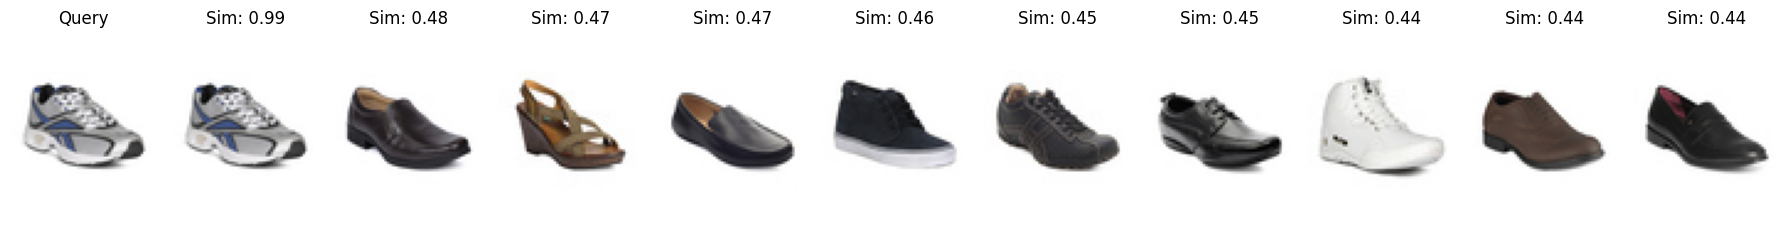


 Tiempo KNN con Índice Invertido: 1.2627 segundos

Top imágenes más similares:
5730: similitud = 0.9904
39265: similitud = 0.4826
55655: similitud = 0.4711
37956: similitud = 0.4672
49494: similitud = 0.4564
5697: similitud = 0.4545
39210: similitud = 0.4488
3675: similitud = 0.4434
44938: similitud = 0.4426
45607: similitud = 0.4402


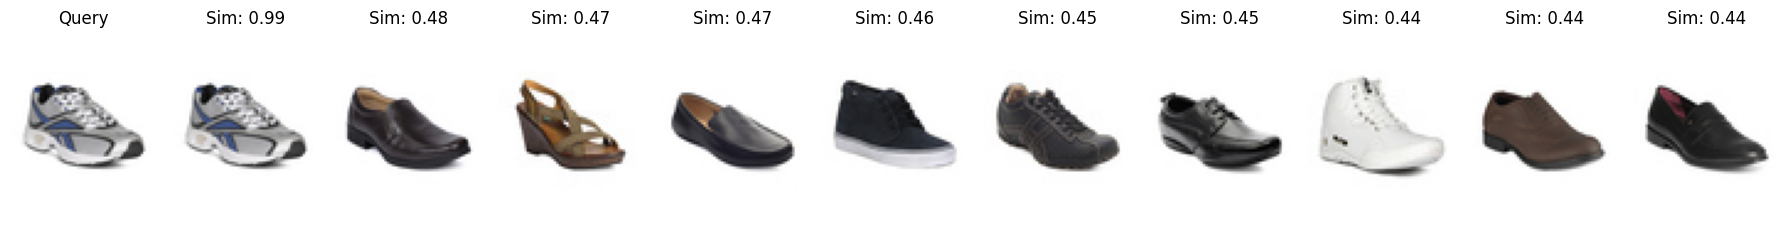

In [37]:
import time

k = 10

# === KNN Secuencial ===
start_time_seq = time.perf_counter()
top_k_results_seq = knn_secuencial(query_histogram, k, idf, all_histograms, image_paths)
end_time_seq = time.perf_counter()

print(f"\n Tiempo KNN Secuencial: {end_time_seq - start_time_seq:.4f} segundos")
print_top_results(top_k_results_seq)
show_top_similar_images(top_k_results_seq, query_path, dataset_path)


# === KNN con Índice Invertido ===
all_histograms_np = np.array(all_histograms, dtype=np.float32)

start_time_inv = time.perf_counter()
inverted_index = construir_indice_invertido(all_histograms)
#top_k_results_inv = knn_con_indice(query_histogram, k, idf, all_histograms, image_paths, inverted_index)
top_k_results_inv = knn_con_indice2(query_histogram, k, idf, all_histograms_np, image_paths, inverted_index)

end_time_inv = time.perf_counter()

print(f"\n Tiempo KNN con Índice Invertido: {end_time_inv - start_time_inv:.4f} segundos")
print_top_results(top_k_results_inv)
show_top_similar_images(top_k_results_inv, query_path, dataset_path)


### Análisis PCA y KMeans

#### PCA

Como son muchos datos y el vector de SIFT es grande podemos utilizar reducción de dimensionalidad. Hacemos un análisis para saber cuantas componentes usamos en el PCA. Utilizamos menos imagenes para ese analisis.

Total images:  1000
Componentes: 10 varianza acumulada: 0.571979.
Componentes: 20 varianza acumulada: 0.734423.
Componentes: 30 varianza acumulada: 0.818874.
Componentes: 40 varianza acumulada: 0.869553.
Componentes: 50 varianza acumulada: 0.906059.
Componentes: 60 varianza acumulada: 0.932594.
Componentes: 70 varianza acumulada: 0.951752.
Componentes: 80 varianza acumulada: 0.966586.
Componentes: 90 varianza acumulada: 0.977817.
Componentes: 100 varianza acumulada: 0.986567.
Componentes: 110 varianza acumulada: 0.993040.
Componentes: 120 varianza acumulada: 0.997689.


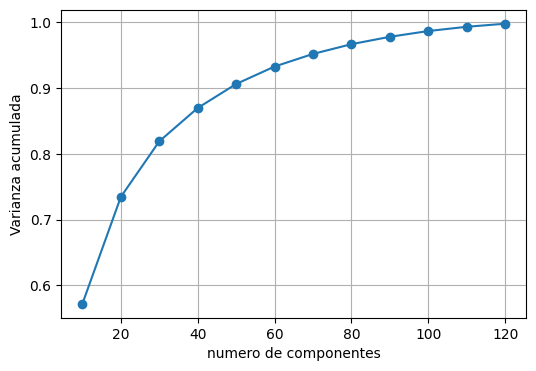

In [39]:
sift_pca = cv2.SIFT_create()
all_descriptors_pca = []

tiny_dataset_path = "../data/fashion_small_1000/" 
#Extraer descriptores
image_filenames_pca = []
for filename in os.listdir(tiny_dataset_path):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        full_path = os.path.join(tiny_dataset_path, filename)
        image_filenames_pca.append(full_path)

total = 0
for file_path in image_filenames_pca: 
    total += 1
    img = cv2.imread(file_path)
    if img is None:
        continue
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift_pca.detectAndCompute(gray, None)
    
    if descriptors is not None:
        all_descriptors_pca.append(descriptors)


print("Total images: ", total)
X_pca = np.vstack(all_descriptors_pca)  # Unir vectores en una matriz

# Aplicar pca
explained_variances = []
components_range = range(10, 130, 10)  # 10 a 120, pasos de 10

for n in components_range:
    pca2= PCA(n_components=n)
    pca2.fit(X_pca)
    explained_var = np.sum(pca2.explained_variance_ratio_)
    print(f"Componentes: {n} varianza acumulada: {explained_var:f}.")
    explained_variances.append(explained_var)

# Graficar
plt.figure(figsize=(6, 4))
plt.plot(components_range, explained_variances, marker='o')
plt.xlabel('numero de componentes')
plt.ylabel('Varianza acumulada')
plt.grid(True)
plt.show()

In [ ]:
# Combinar todos los descriptores reducidos en una sola matriz
#X2 = np.vstack(descriptors)  # Esto es antes de aplicar KMeans
#labels = kmeans.labels_     # Etiquetas de los clusters para cada descriptor

# Reducir a 2D para visualizar
#pca_vis = PCA(n_components=2)
#X_2d = pca_vis.fit_transform(X2)

# Graficar
#plt.figure(figsize=(10, 6))
#scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab20', s=1, alpha=0.6)
#plt.title("Visualizacion de clusters (KMeans sobre SIFT-PCA)")
#plt.xlabel("PCA Componente 1")
#plt.ylabel("PCA Componente 2")
#plt.colorbar(scatter, label="Cluster")
#plt.grid(True)
#plt.show()


## Experimentación



Probando con 1000 vectores…

Probando con 2000 vectores…

Probando con 4000 vectores…

Probando con 8000 vectores…

Probando con 16000 vectores…

Probando con 32000 vectores…

Probando con 64000 vectores…

Tiempos promedio (s):
  Secuencial: [0.044, 0.0895, 0.1966, 0.3573, 0.9109, 1.4513, 2.9061]
  Índice Inv.: [0.0013, 0.0017, 0.0048, 0.009, 0.0187, 0.0358, 0.0875]
  Postgres: [0.0017, 0.0019, 0.0033, 0.0049, 0.08, 0.1063, 0.1231]


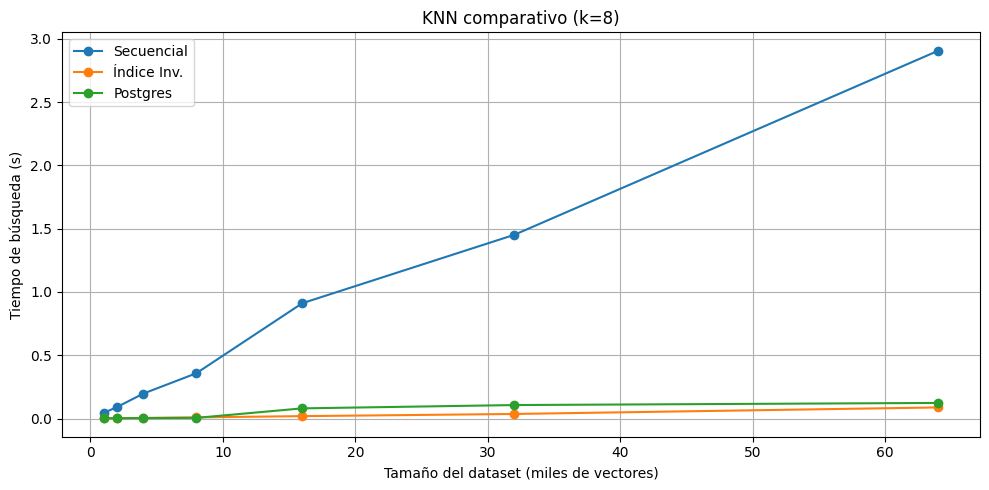

In [46]:
import os
import time
import numpy as np
import psycopg2
import matplotlib.pyplot as plt

# --- CONFIG PostgreSQL ---
PG_CONFIG = {
    "host": "localhost",
    "port": 5432,
    "dbname": "proyecto_final",
    "user": "postgres",
    "password": "postgres"
}
TABLE      = "image_vectors"
VECTOR_DIM = tf_idf.shape[1]  # dim de tus vectores TF-IDF

# --- Parámetros de prueba ---
dataset_sizes = [1_000, 2_000, 4_000, 8_000, 16_000, 32_000, 64_000] #la data solo llega hasta 44k, duplicamos algunos datos para 64k
k = 8              # vecinos
repeats = 5        # cuántas veces repetimos cada medida
output_png = "knn_comparison_images.png"

# Prepara la query
query_hist = create_query_histogram(query_path, kmeans, pca)

# Función de soporte: poblar Postgres
def setup_pg(conn, tfidf, paths):
    cur = conn.cursor()
    cur.execute("CREATE EXTENSION IF NOT EXISTS vector;")
    cur.execute(f"DROP TABLE IF EXISTS {TABLE};")
    cur.execute(f"""
        CREATE TABLE {TABLE} (
          id SERIAL PRIMARY KEY,
          image_name TEXT,
          vec VECTOR({VECTOR_DIM})
        );
    """)
    # inserta todos
    records = [
        (paths[i], tfidf[i].tolist())
        for i in range(len(paths))
    ]
    args_str = ",".join(cur.mogrify("(%s, %s)", r).decode()
                        for r in records)
    cur.execute(f"INSERT INTO {TABLE}(image_name, vec) VALUES {args_str};")
    conn.commit()
    cur.close()

# Función de búsqueda en Postgres
def knn_pg(conn, qvec, k):
    cur = conn.cursor()
    # preformatea el vector como literal pgvector
    vec_str = "[" + ",".join(f"{v:.6f}" for v in qvec) + "]"
    start = time.perf_counter()
    cur.execute(f"""
        SELECT image_name
        FROM {TABLE}
        ORDER BY vec <-> '{vec_str}'
        LIMIT %s;
    """, (k+1,))  # +1 para descartar la query
    rows = cur.fetchall()
    elapsed = time.perf_counter() - start
    cur.close()
    # descarta la query y devuelve k
    results = [r[0] for r in rows if r[0] != os.path.basename(query_path)]
    return results[:k], elapsed

# Conectarse a Postgres
conn = psycopg2.connect(**PG_CONFIG)

times_seq = []
times_inv = []
times_pg  = []

for n in dataset_sizes:
    print(f"\nProbando con {n} vectores…")
    idxs    = np.arange(n)

    # "Duplicar" los datos para poder llegar a los 64k
    repeats_needed = (n + len(tf_idf) - 1) // len(tf_idf)
    tfidf_n = np.tile(tf_idf, (repeats_needed, 1))[:n]
    paths_n = (list(image_paths) * repeats_needed)[:n]


    # Prepara índice en memoria (una sola vez por tamaño)
    all_hist_np    = np.array(tfidf_n, dtype=np.float32)
    inverted_index = construir_indice_invertido(tfidf_n.tolist())

    # Prepara Postgres
    setup_pg(conn, tfidf_n, paths_n)

    # Listas para acumular repeticiones
    seq_times = []
    inv_times = []
    pg_times  = []

    for _ in range(repeats):
        # 1) Secuencial
        t0 = time.perf_counter()
        knn_secuencial(query_hist, k, idf, tfidf_n.tolist(), paths_n)
        seq_times.append(time.perf_counter() - t0)

        # 2) Índice invertido
        t0 = time.perf_counter()
        knn_con_indice2(query_hist, k, idf, all_hist_np, paths_n, inverted_index)
        inv_times.append(time.perf_counter() - t0)

        # 3) PostgreSQL
        _, t_pg = knn_pg(conn, query_hist, k)
        pg_times.append(t_pg)

    # Guarda el promedio de cada método
    times_seq.append( sum(seq_times)/repeats )
    times_inv.append( sum(inv_times)/repeats )
    times_pg.append(  sum(pg_times)/repeats  )

conn.close()

# Imprime y grafica
print("\nTiempos promedio (s):")
for label, arr in zip(
    ["Secuencial","Índice Inv.","Postgres"],
    [times_seq, times_inv, times_pg]
):
    print(f"  {label}: {[round(x,4) for x in arr]}")

plt.figure(figsize=(10,5))
for arr, label in zip([times_seq, times_inv, times_pg],
                      ["Secuencial","Índice Inv.","Postgres"]):
    plt.plot([x/1000 for x in dataset_sizes], arr,
             marker='o', label=label)

plt.xlabel("Tamaño del dataset (miles de vectores)")
plt.ylabel("Tiempo de búsqueda (s)")
plt.title(f"KNN comparativo (k={k})")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig(output_png)
plt.show()
